In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1. 데이터 불러오기

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


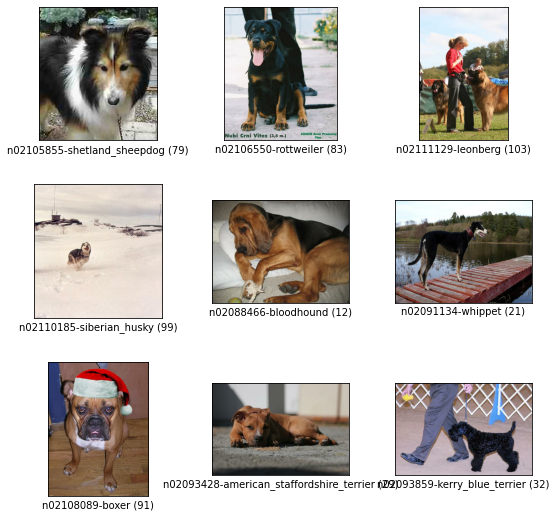

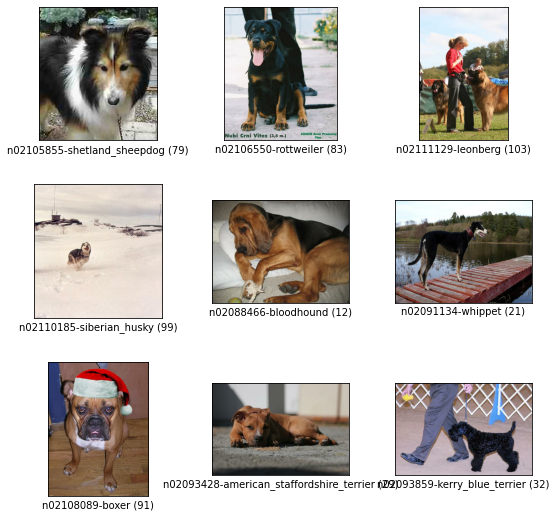

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

tfds.show_examples(ds_train, ds_info)

2. Augmentation 적용하기

In [3]:
# make random augment function
def augment2(image,label):
    # 이미지를 무작위로 좌우 반전
    image = tf.image.random_flip_left_right(image)
    
    # 이미지를 무작위로 상하 반전
    image = tf.image.random_flip_up_down(image)
    
    # 이미지를 무작위로 90도 회전 (0, 90, 180, 270도 중 하나)
    image = tf.image.random_rotation(image, max_delta=0.25)  # 0.25는 90도의 비율
    
    # 이미지를 무작위로 밝기 조정
    image = tf.image.random_brightness(image, max_delta=0.2)
    
    # 이미지를 무작위로 대비 조정
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # 이미지를 무작위로 크롭하고 크기를 다시 조정
    image = tf.image.random_crop(image, size=[int(image.shape[0] * 0.8), int(image.shape[1] * 0.8), 3])
    image = tf.image.resize(image, [image.shape[0], image.shape[1]])

    # 증강 후 이미지와 레이블 반환
    return image, label

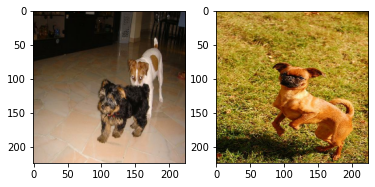

In [25]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [18]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(200, shape=(), dtype=int32)
y :  tf.Tensor(138, shape=(), dtype=int32) tf.Tensor(200, shape=(), dtype=int32)


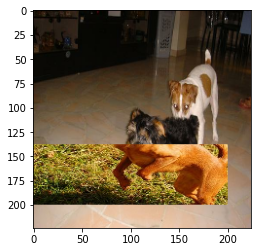

In [26]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [27]:
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.7528699, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [4]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max


# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img


# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [5]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


# 배치 단위
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [6]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(
    ds, is_test=False, 
    batch_size=16, 
    with_aug=False, 
    with_cutmix=False,
    with_mixup=False
):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

3. 비교실험 하기

In [7]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [8]:
# Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [10]:
# Cutmix를 적용한 데이터셋으로 학습시킬 ResNet
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [11]:
# mixUp을 적용한 데이터셋으로 학습시킬 ResNet
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
# 데이터 전처리
EPOCH=20
LEARNING_RATE=0.001
BATCH_SIZE=16


(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,    # 각 에포크 간에 파일을 섞을지 여부 
    with_info=True,    # tfds.core.DatasetInfo(메타데이터)를 반환
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE, is_test=True)

In [32]:
EPOCH=20
LEARNING_RATE=0.001
BATCH_SIZE=16

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="img_augmentation.keras",
      save_best_only=True,
      monitor="val_loss")
]

In [14]:
from tensorflow.keras.callbacks import CSVLogger


MODEL_NAME='resnet50'
# CSVLogger 콜백을 통해 학습 과정 기록을 CSV 파일로 저장
csv_logger = CSVLogger(f"training_log_{MODEL_NAME}_lr{LEARNING_RATE}_b{BATCH_SIZE}.csv")

print(f"training_log_{MODEL_NAME}_lr{LEARNING_RATE}_b{BATCH_SIZE}")
DS_TRAIN=ds_train_no_aug # augmentation 적용하지 않은 데이터셋 사용

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
          filepath=f"img_augmentation_{MODEL_NAME}.keras",
          save_best_only=True,
          monitor="val_loss"),
        csv_logger
    ]
)

Epoch 1/20
750/750 [==============================] - 200s 207ms/step - loss: 2.2254 - accuracy: 0.4504 - val_loss: 3.3431 - val_accuracy: 0.2107


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 0.7559 - accuracy: 0.7885 - val_loss: 1.1624 - val_accuracy: 0.6662
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.2697 - accuracy: 0.9393 - val_loss: 0.9388 - val_accuracy: 0.7220
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0730 - accuracy: 0.9927 - val_loss: 0.9087 - val_accuracy: 0.7367
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0281 - accuracy: 0.9987 - val_loss: 0.9211 - val_accuracy: 0.7368
Epoch 6/20
750/750 [==============================] - 155s 206ms/step - loss: 0.0172 - accuracy: 0.9994 - val_loss: 0.9349 - val_accuracy: 0.7403
Epoch 7/20
750/750 [==============================] - 155s 206ms/step - loss: 0.0120 - accuracy: 0.9998 - val_loss: 0.9413 - val_accuracy: 0.7392
Epoch 8/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.9515 -

resnet50 결과 분석
- 훈련 손실(loss)은 2.2254에서 0.0027까지 꾸준히 감소하는데 Epoch 8 이후 개선이 크지 않음
- 훈련 정확도(accuracy)는 45.04%에서 시작해서 100.00%까지 상승하는데 Epoch 4에 99.27%까지 상승하고 이후 개선이 크지 않음
- 검증 손실(val_loss)은 3.3431에서 시작해서 0.9087정도까지 내려가지만 Epoch 4까지 감소하다가 이후 증가 경향까지 보이는 걸로 봐서 과적합.
- 검증 정확도(val_accuracy)는 21.07%에서 시작해서 74.03%까지 상승했지만 Epoch 6에 73~74% 정도가 나온 이후 왔다갔다 함


결론
- 훈련의 경우 거의 완벽하게 학습을 완료한 것으로 보임. 하지만 훈련 손실 대비 검증 손실의 경우 변동이 있는 걸로 보아 과적합 의심됨
- Epoch 4 이후 검증 손실이 증가하는 경향이 보이고 정확도도 개선 정도가 크지 않기 때문에 여기서 멈춤

In [17]:
MODEL_NAME='aug_resnet50'
# CSVLogger 콜백을 통해 학습 과정 기록을 CSV 파일로 저장
csv_logger = CSVLogger(f"training_log_{MODEL_NAME}_lr{LEARNING_RATE}_b{BATCH_SIZE}.csv")
print(f"training_log_{MODEL_NAME}_lr{LEARNING_RATE}_b{BATCH_SIZE}")
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
          filepath=f"img_augmentation_{MODEL_NAME}.keras",
          save_best_only=True,
          monitor="val_loss"),
        csv_logger
    ]
)

Epoch 1/20
750/750 [==============================] - 164s 208ms/step - loss: 2.3003 - accuracy: 0.4232 - val_loss: 2.6094 - val_accuracy: 0.3257
Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 0.9482 - accuracy: 0.7272 - val_loss: 1.2885 - val_accuracy: 0.6271
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 0.4764 - accuracy: 0.8721 - val_loss: 1.1134 - val_accuracy: 0.6734
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 0.2546 - accuracy: 0.9404 - val_loss: 0.9917 - val_accuracy: 0.7148
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 0.1445 - accuracy: 0.9725 - val_loss: 0.9822 - val_accuracy: 0.7128
Epoch 6/20
750/750 [==============================] - 155s 206ms/step - loss: 0.0790 - accuracy: 0.9876 - val_loss: 0.9507 - val_accuracy: 0.7303
Epoch 7/20
750/750 [==============================] - 155s 206ms/step - loss: 0.0495 - accuracy: 0.9938 - val_loss: 0.9875 -

aug_resnet50 결과 분석
- 훈련 손실(loss)은 2.3003에서 0.0040까지 감소하는데 Epoch 7 이후 개선이 크지 않음
- 훈련 정확도(accuracy)는 42.32%에서 시작해서 100.00%까지 상승하는데 Epoch 7 이후 개선이 크지 않음
- 검증 손실(val_loss)은 2.6094에서 시작해서 Epoch 6에 0.9507정도까지 내려가지만 이후 계속해서 1.0554까지 왔다갔다 함. 과적합 가능성 있음
- 검증 정확도(val_accuracy)는 32.57%에서 시작해서 74.46%까지 상승했지만 Epoch 6에 73% 정도가 나온 이후 개선폭이 크지 않음


결론
- 훈련의 경우 거의 완벽하게 학습을 완료한 것으로 보임. 하지만 훈련 손실 대비 검증 손실의 경우 변동이 있는 걸로 보아 과적합 의심됨
- Epoch 6에서 검증 성능이 최적임

In [15]:
MODEL_NAME='cutmix_resnet50'
# CSVLogger 콜백을 통해 학습 과정 기록을 CSV 파일로 저장
csv_logger = CSVLogger(f"training_log_{MODEL_NAME}_lr{LEARNING_RATE}_b{BATCH_SIZE}.csv")
print(f"training_log_{MODEL_NAME}_lr{LEARNING_RATE}_b{BATCH_SIZE}")
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
          filepath=f"img_augmentation_{MODEL_NAME}.keras",
          save_best_only=True,
          monitor="val_loss"),
        csv_logger
    ]
)

Epoch 1/20
750/750 [==============================] - 177s 215ms/step - loss: 3.9108 - accuracy: 0.1899 - val_loss: 3.4400 - val_accuracy: 0.1897
Epoch 2/20
750/750 [==============================] - 160s 214ms/step - loss: 3.0254 - accuracy: 0.4090 - val_loss: 1.3587 - val_accuracy: 0.6126
Epoch 3/20
750/750 [==============================] - 165s 220ms/step - loss: 2.7519 - accuracy: 0.4918 - val_loss: 1.4669 - val_accuracy: 0.5962
Epoch 4/20
750/750 [==============================] - 166s 221ms/step - loss: 2.5716 - accuracy: 0.5464 - val_loss: 1.2940 - val_accuracy: 0.6420
Epoch 5/20
750/750 [==============================] - 164s 219ms/step - loss: 2.4245 - accuracy: 0.5978 - val_loss: 1.1480 - val_accuracy: 0.6742
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 2.3184 - accuracy: 0.6288 - val_loss: 1.2923 - val_accuracy: 0.6486
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 2.2114 - accuracy: 0.6673 - val_loss: 1.4114 -

cutmix_resnet50 결과 분석

- 훈련 손실(loss)은 감소하는 경향을 보이다 Epoch 16~20 사이에 1.7177~1.7767 수준으로 수렴
- 훈련 정확도(accuracy)는 18.99%에서 시작해서 79.14%까지 꾸준히 상승하는 모습을 보임
- 검증 손실(val_loss)은 3.4400에서 시작해서 1.2정도까지 내려가지만 계속해서 1.2~1.3정도를 왔다갔다 함. 
- 검증 정확도(val_accuracy)는 18.97%에서 시작해서 68.41%까지 상승했지만 Epoch 10 이후 딱히 증가하지 않고 왔다갔다 함


결론
- 훈련손실의 경우 수렴하는 듯 보이지만 검증 손실이 Epoch 6 이후 계속 변동하는 걸로 봐서 수렴했다고 볼 수 없음
- 훈련 손실이 수렴하는 것과 달리 검증 손실이 수렴하지 않고 변동이 큰 걸로 봐서는 과적합 가능성 있음
- Epoch 5에서 검증 손실 및 정확도가 베스트 값을 보임

In [16]:
MODEL_NAME='mixup_resnet50'
# CSVLogger 콜백을 통해 학습 과정 기록을 CSV 파일로 저장
csv_logger = CSVLogger(f"training_log_{MODEL_NAME}_lr{LEARNING_RATE}_b{BATCH_SIZE}.csv")
print(f"training_log_{MODEL_NAME}_lr{LEARNING_RATE}_b{BATCH_SIZE}")
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
          filepath=f"img_augmentation_{MODEL_NAME}.keras",
          save_best_only=True,
          monitor="val_loss"),
        csv_logger
    ]
)

Epoch 1/20
750/750 [==============================] - 170s 216ms/step - loss: 3.7873 - accuracy: 0.2210 - val_loss: 3.8982 - val_accuracy: 0.1067
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 2.9286 - accuracy: 0.4529 - val_loss: 1.4043 - val_accuracy: 0.6088
Epoch 3/20
750/750 [==============================] - 161s 214ms/step - loss: 2.6675 - accuracy: 0.5374 - val_loss: 1.4658 - val_accuracy: 0.5831
Epoch 4/20
750/750 [==============================] - 175s 233ms/step - loss: 2.5158 - accuracy: 0.6022 - val_loss: 1.4188 - val_accuracy: 0.6123
Epoch 5/20
750/750 [==============================] - 158s 211ms/step - loss: 2.3808 - accuracy: 0.6510 - val_loss: 1.3402 - val_accuracy: 0.6370
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 2.2735 - accuracy: 0.6947 - val_loss: 1.3434 - val_accuracy: 0.6336
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 2.2198 - accuracy: 0.7179 - val_loss: 1.2225 -

mixup_resnet50 결과 분석

- 훈련 손실(loss)은 감소하는 경향을 보이다 Epoch 15~20 사이에 1.7901~1.8812 수준으로 수렴
- 훈련 정확도(accuracy)는 22.10%에서 시작해서 85.33%까지 상승하는데 Epoch 18 이후 84~85% 사이에서 수렴하는 듯한 모습을 보임
- 검증 손실(val_loss)은 3.8982에서 시작해서 1.2정도까지 내려가지만 Epoch9 이후 계속해서 1.2~1.4정도를 왔다갔다 함
- 검증 정확도(val_accuracy)는 18.97%에서 시작해서 68.11%까지 상승했지만 변동이 심함

결론
- 훈련 손실은 수렴하는데 반해서 검증 손실의 경우 Epoch 9 이후 변동이 큰 모습을 보임
- 따라서 Epoch 9 이후 과적합 가능성이 있음
- Epoch 8 이후 검증 정확도 변동성의 변화가 큰 걸로 봐서는 일반화 성능 개선이 안됨

learning rate 0.001로 변경해서 재실험

In [33]:
# learning rate 0.001로 변경

MODEL_NAME='cutmix_resnet50'
# CSVLogger 콜백을 통해 학습 과정 기록을 CSV 파일로 저장
csv_logger = CSVLogger(f"training_log_{MODEL_NAME}_lr{LEARNING_RATE}_b{BATCH_SIZE}.csv")
print(f"training_log_{MODEL_NAME}_lr{LEARNING_RATE}_b{BATCH_SIZE}")
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
          filepath=f"img_augmentation_{MODEL_NAME}.keras",
          save_best_only=True,
          monitor="val_loss"),
        csv_logger
    ]
)

training_log_cutmix_resnet50_lr0.001_b16
Epoch 1/20
750/750 [==============================] - 164s 208ms/step - loss: 1.6123 - accuracy: 0.8278 - val_loss: 1.0892 - val_accuracy: 0.7369
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 1.5835 - accuracy: 0.8376 - val_loss: 1.0945 - val_accuracy: 0.7362
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 1.5657 - accuracy: 0.8335 - val_loss: 1.0897 - val_accuracy: 0.7415
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 1.5511 - accuracy: 0.8368 - val_loss: 1.0970 - val_accuracy: 0.7395
Epoch 5/20
750/750 [==============================] - 156s 207ms/step - loss: 1.5532 - accuracy: 0.8382 - val_loss: 1.0782 - val_accuracy: 0.7416
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 1.5577 - accuracy: 0.8373 - val_loss: 1.0920 - val_accuracy: 0.7449
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 1.519

In [ ]:
# learning rate 0.001로 변경

MODEL_NAME='mixup_resnet50'
# CSVLogger 콜백을 통해 학습 과정 기록을 CSV 파일로 저장
csv_logger = CSVLogger(f"training_log_{MODEL_NAME}_lr{LEARNING_RATE}_b{BATCH_SIZE}.csv")
print(f"training_log_{MODEL_NAME}_lr{LEARNING_RATE}_b{BATCH_SIZE}")
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
          filepath=f"img_augmentation_{MODEL_NAME}.keras",
          save_best_only=True,
          monitor="val_loss"),
        csv_logger
    ]
)

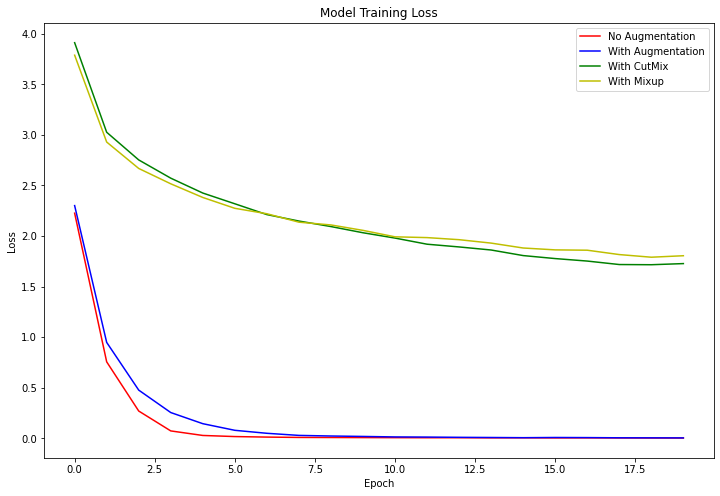

In [28]:
# 훈련 손실 그래프 비교
plt.figure(figsize=(12,8))

plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_cutmix.history['loss'], 'g')
plt.plot(history_resnet50_mixup.history['loss'], 'y')
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], 
           loc='upper right')
plt.show()

- No Augmentation, With Augmentation, With CutMix, With Mixup 모델 결과 비교

- 

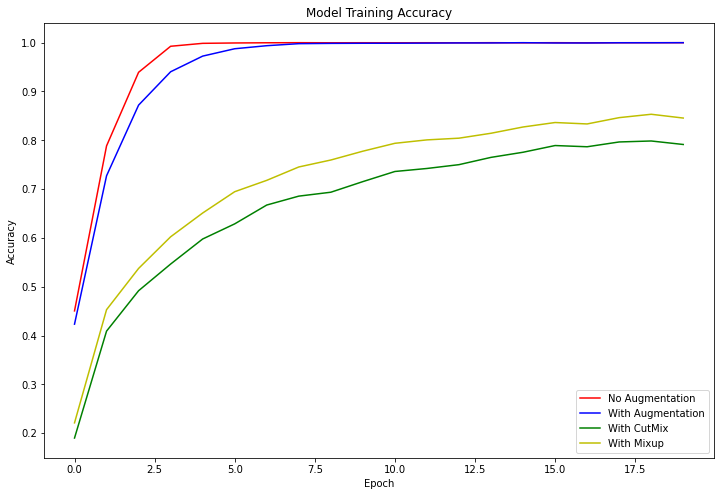

In [21]:
# 검증 손실 그래프 비교
plt.figure(figsize=(12,8))

plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['accuracy'], 'y')
plt.title('Model Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], 
           loc='lower right')
plt.show()

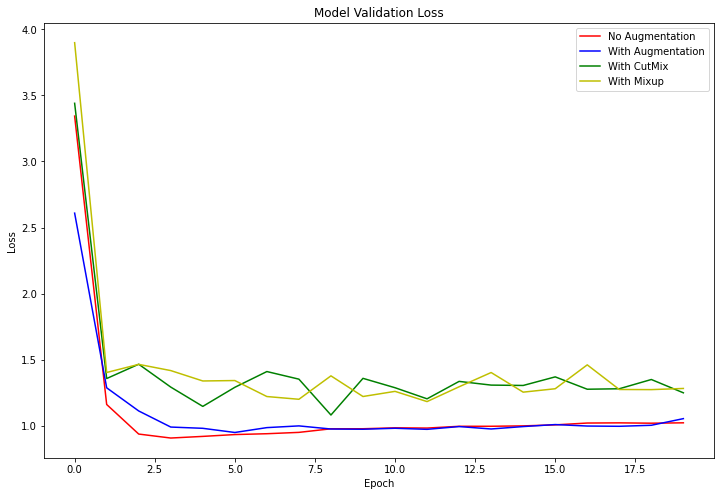

In [26]:
plt.figure(figsize=(12,8))

plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'y')
plt.title('Model Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], 
           loc='upper right')
plt.show()

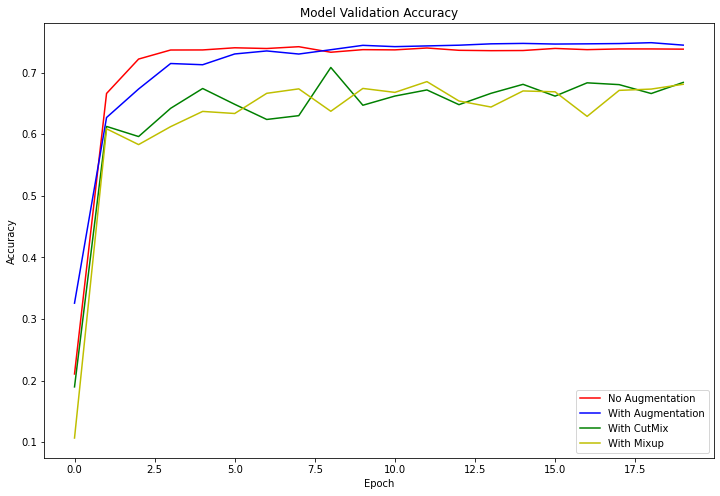

In [27]:
plt.figure(figsize=(12,8))

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], 
           loc='lower right')
plt.show()

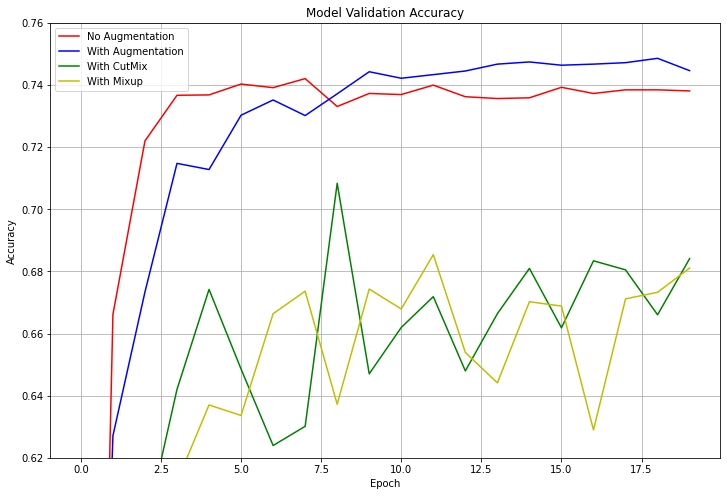

In [31]:
plt.figure(figsize=(12,8))

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], 
           loc='upper left')
plt.grid(True)
plt.ylim(0.62, 0.76)  # 출력하고자 하는  Accuracy 범위 설정
plt.show()

1. 훈련 성능
- 전반적으로 모델의 성능은 No Augmentation, With Augmentation, With CutMix, With MixUp 순서로 좋음 
- No Augmentation, With Augmentation 모델의 경우 훈련 데이터에 대해서는 거의 완벽하게 학습해서 과적합 가능성을 보임
- With CutMix, With MixUp 모델도 과적합의 가능성은 보이지만 훈련 손실이 1에서 더 낮아지지 않은 걸로 봐서 과도하게 적응하지 않았다고 볼 수 있음

2. 검증 성능
- No Augmentation, With Augmentation 모델의 경우 정확도가 높지만 훈련과 검증 성능 차이가 커서 일반화 성능이 떨어질 것으로 예상됨
- With CutMix, With MixUp 모델 역시 과적합이 우려되지만 훈련, 검증 성능 간 차이가 덜하고, 과적합이 덜 발생한 걸로 볼 수 있음

3. 모델 수렴 여부
- No Augmentation, With Augmentation 모델의 경우 훈련 데이터에는 수렴했지만 검증 손실이 크게 감소하지 않고 오히려 증가하는 등 불안정함
- With CutMix, With MixUp 모델의 경우 앞선 두 모델 대비 수렴했다고 볼 수 있지만 일반화 성능 개선 필요

개선 방향
    1.	과적합 방지 기법 적용: Dropout, L2 정규화, 데이터 증강 등을 통해 과적합을 방지
	2.	Early Stopping 적용: 검증 성능이 최고점에 도달한 시점에 학습을 멈춰 과적합을 방지
	3.	학습률 조정: 학습률을 줄이거나 배치 크기를 조정하여 모델의 일반화 성능을 개선

회고
- 분석을 나중에 시작했더니 개선 방향을 적용해보지 못해서 아쉽다.